# Import Libraries and data

Import Libraries

In [122]:
import nltk
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import wordpunct_tokenize, word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

ps = PorterStemmer()

sw = stopwords.words('english')

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve

In [134]:
from collections import defaultdict
from sklearn import model_selection, naive_bayes, svm
from sklearn.preprocessing import LabelEncoder

Import Data

In [170]:
data = pd.read_csv("https://bd.darrenmcewan.com/ratings.tsv", sep='\t')
data.review=data.review.astype(str)
data.head()

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...


# Data Cleaning and Split in Train/Test Set

There were 55 rows that were empty. Dropping them leave us with 7945 rows of data to work with

In [171]:
#Drop blank rows
data['review'].replace('', np.nan, inplace=True)
data.dropna(subset=['review'],inplace=True)
data.dropna(subset=['label'],inplace=True)

#All words to lowercase
data['review'] = [entry.lower() for entry in data['review']]

#tokenization
data['review']= [word_tokenize(entry) for entry in data['review']]

In [172]:
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(data['review']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    data.loc[index,'review_final'] = str(Final_words)

Split the data into train/test set

In [186]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data['review_final'],data['label'],test_size=0.33,random_state=80)
#y_train.dropna(inplace=True)
#y_test.dropna(inplace=True)


In [187]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

# Word Vectorization

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=5000, stop_words='english', min_df=.01, max_df=.90)
Tfidf_vect.fit(data['review_final'])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)
print(Tfidf_vect.vocabulary_)

## TF-IDF Based on Count Vectorizer

This function will take in a dataset and use countVectorizer to make a df based on word and # of occurrences and also a df based on word and the term weights. I decided to return the 2nd df

In [93]:
def tf_idf(dataset): 

  countVec = CountVectorizer(max_features= 5000, stop_words='english', min_df=.01, max_df=.90)

  countVec.fit(dataset["review"])
  #useful debug, get an idea of the item list you generated
  #list(countVec.vocabulary_.items())

  countVec_count = countVec.transform(dataset["review"])
  occ = np.asarray(countVec_count.sum(axis=0)).ravel().tolist()

  bowListFrame = pd.DataFrame({'term': countVec.get_feature_names(), 'occurrences': occ})
  #print(bowListFrame)
  #bowListFrame.sort_values(by='occurrences', ascending=False).head(60)

  reviewTransformer = TfidfTransformer()

  #initial fit representation using transformer object
  reviewWeights = reviewTransformer.fit_transform(countVec_count)

  #follow similar process to making new data frame with word occurrences, but with term weights
  reviewWeightsFin = np.asarray(reviewWeights.mean(axis=0)).ravel().tolist()

  #now that we've done Tfid, make a dataframe with weights and names
  reviewWeightFrame = pd.DataFrame({'term': countVec.get_feature_names(), 'weight': reviewWeightsFin})
  #print(reviewWeightFrame)
  reviewWeightFrame=reviewWeightFrame.sort_values(by='weight', ascending=False).head(20)  
  return reviewWeightFrame




In [100]:
testWeightFrame = tf_idf(test)
trainWeightFrame = tf_idf(train)

print(trainWeightFrame)
print("\n",testWeightFrame)

            term    weight
203           br  0.116480
1173       movie  0.072367
669         film  0.064829
1033        like  0.034752
961         just  0.032627
766         good  0.028274
1800        time  0.026374
139          bad  0.024863
1681       story  0.024827
1426      really  0.024106
779        great  0.022622
1174      movies  0.021719
1284      people  0.021582
501          don  0.021578
1545        seen  0.019935
1088        make  0.019760
1927       watch  0.019162
274   characters  0.019142
1069        love  0.018851
1931         way  0.018690

             term    weight
209           br  0.117084
1127       movie  0.071765
643         film  0.064046
991         like  0.035206
920         just  0.032098
739         good  0.028146
144          bad  0.026528
1742        time  0.026360
1636       story  0.025983
1378      really  0.024578
1238      people  0.022421
751        great  0.021817
1128      movies  0.021506
485          don  0.021203
271   characters  0.019765

## TF-IDF Based on Tfidf Vectorizer

In [178]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    

In [179]:
y_train = (train['label']=='neg').astype(int)
y_test = (test['label']=='neg').astype(int)

tfidf = TfidfVectorizer(max_features= 5000, stop_words='english', min_df=.01, max_df=.90)
tfidf.fit(train['review'])
X_train = tfidf.transform(train['review'])
X_test = tfidf.transform(test['review'])

In [180]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
yhat = nb.predict(X_test)
print(accuracy_score(y_test, yhat))
print(f1_score(y_test, yhat))
print(precision_score(y_test, yhat))
print(recall_score(y_test, yhat))

0.8775743707093822
0.8783630162940508
0.8727409638554217
0.8840579710144928


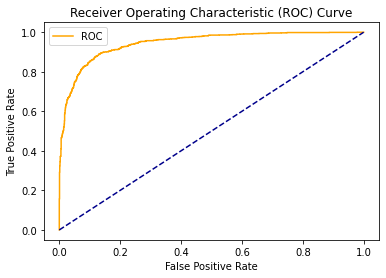

0.9454239518804971


In [181]:
y_prob = nb.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, y_prob)
plot_roc_curve(fpr, tpr)
print(roc_auc_score(y_test, y_prob))

In [182]:
feats = pd.DataFrame()
feats['words'] = tfidf.get_feature_names()
# Convert log probabilities to probabilities. 
feats['pos'] = np.e**(nb.feature_log_prob_[0, :])
feats['neg'] = np.e**(nb.feature_log_prob_[1, :])
feats.set_index('words', inplace=True)

In [202]:
feats.sort_values(by='pos',ascending=False).head(15)

,pos,neg
words,,
br,0.013986,0.016294
film,0.008824,0.008097
movie,0.008104,0.010730
great,0.004443,0.001557
like,0.004037,0.005061
story,0.003742,0.002806
good,0.003716,0.003715
just,0.003636,0.004908
time,0.003471,0.003466


In [201]:
feats.sort_values(by='neg',ascending=False).head(15)

,pos,neg
words,,
br,0.013986,0.016294
movie,0.008104,0.010730
film,0.008824,0.008097
bad,0.000983,0.005508
like,0.004037,0.005061
just,0.003636,0.004908
good,0.003716,0.003715
time,0.003471,0.003466
don,0.002221,0.003457


### Which words are most important for distinguishing between pos and neg reviews?

Great, like, story, love, best, people are all words that had a high weight when it came to positive words. 

bad, just, time, plot, acting, and worst are words that scored high according to negative reviews. 

#ML Models

According to our score, SVM performed the best with an accuracy score of 87.19%, followed by NB with an accuracy score of 85%. MLP had the lowest score with 84%.

## Naive Bayes

In [188]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,y_train)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_test)*100)

Naive Bayes Accuracy Score ->  85.3030303030303


## SVM

In [189]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,y_train)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  87.19696969696969


## Multilayer Perceptron


In [200]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(solver='lbfgs', alpha=1e-3, random_state=3)
MLP.fit(Train_X_Tfidf,y_train)


predictions_MLP = MLP.predict(Test_X_Tfidf)
print("MLP Accuracy Score -> ",accuracy_score(predictions_MLP, y_test)*100)

MLP Accuracy Score ->  83.56060606060606


# Vader Sentiment Analysis

In [205]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [228]:
def sentiment_scores(sentence):
  sid_obj = SentimentIntensityAnalyzer()
  sentiment_dict = sid_obj.polarity_scores(sentence)

  # decide sentiment as positive, negative and neutral 
  if sentiment_dict['compound'] >= 0.05 : 
        print("Positive") 
  
  elif sentiment_dict['compound'] <= - 0.05 : 
        print("Negative") 
  
  else : 
        print("Neutral") 
  #print("{:-<40} {}".format(sentence, str(sentiment_dict)))

In [229]:
for i in range(10):
  sentiment_scores(data['review'][i])



Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral


The Vader sentiment analysis was terribly innacurate for my data

# Text Blob

In [232]:
from textblob import TextBlob

def blobSentiment(text):
  blob = TextBlob(text)
  for sentence in blob.sentences:
    print(sentence.sentiment.polarity)

for i in range(10):
  sentiment_scores(data['review'][i])

Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral


# Topic Modeling


Run LDA topic modeling using gensim on the movie reviews. How many topics are there? What are
the most common words in each topic?


In [239]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
ntopics = 8

# Create Dictionary

id2word = corpora.Dictionary(data['review'])

# Create Corpus: Term Document Frequency

corpus = [id2word.doc2bow(text) for text in data.review]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=ntopics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

ldatopics = lda_model.show_topics(formatted=False)
pprint(lda_model.print_topics())